In [1]:
import os
import csv
import json
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import clip
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets, transforms

In [2]:
def set_same_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_same_seed(0)

In [3]:
def normolize(x):
    a, b = x.min(), x.max()
    return (x-a)/(b-a)

def csv2list(csv_path):
    gt = []
    with open(csv_path, newline='') as file:
        rows = csv.reader(file)
        for row in rows:
            gt.append(row)
    gt.pop(0)
    return gt

def csv_output(test_gt: list, csv_path: str):
    test_gt_copy = test_gt.copy()
    test_gt_copy.insert(0, ['filename', 'label'])
    with open(csv_path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(test_gt_copy)
        
def check_csv_acc(csv_path):
    gt = csv2list(csv_path)
    gt.pop(0)
    total = len(gt)
    acc = 0
    for (n, p) in gt:
        if n.split('_')[0] == p:
            acc += 1
    acc /= total
    return acc

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [5]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x000002172C7D4670>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [6]:
class TestDataset(Dataset):
    def __init__(self, img_dir, transform=preprocess):
        self.img_dir = img_dir
        self.img_list = [file for file in os.listdir(img_dir) if file.endswith('.png')]
        self.transform = transform
        self.img_list.sort()

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_name = self.img_list[idx]
        img_path = f'{self.img_dir}/{img_name}'
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, img_name

In [7]:
test_image_dir = 'hw3_data/p1_data/val/'
test_dataset = TestDataset(test_image_dir)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=False)

Feature batch shape: torch.Size([100, 3, 224, 224])


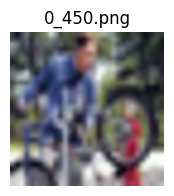

torch.Size([3, 224, 224])


In [8]:
images, img_name = next(iter(test_dataloader))
print(f"Feature batch shape: {images.size()}")
idx = 0
plt.figure(figsize=(2,2))
plt.imshow(normolize(images[idx].moveaxis(0, 2)))
plt.title(img_name[idx])
plt.axis('off')
plt.show()
print(images[idx].shape)

In [9]:
with open('hw3_data/p1_data/id2label.json', newline='') as file:
    json_dict = json.load(file)
json_values = list(json_dict.values())
json_keys = list(json_dict.keys())

In [26]:
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}.") for c in json_values]).to(device)

In [27]:
test_gt = []

model.eval()
for i, (images, names) in enumerate(test_dataloader):
    print(i, end='\r')
    image_input = images.to(device)
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    for j, s in enumerate(similarity):
        test_gt.append([names[j], s.argmax().item()])

In [28]:
csv_path = 'test_gt.csv'
csv_output(test_gt, csv_path)

In [25]:
check_csv_acc(csv_path) # No {c}, no score.

0.5630252100840336

In [21]:
check_csv_acc(csv_path) # This is a {c} image.

0.6818727490996399

In [17]:
check_csv_acc(csv_path) # This is a photo of {c}

0.6086434573829532

In [29]:
check_csv_acc(csv_path) # a photo of a {c}.

0.7126850740296119

In [6]:
check_csv_acc('D:/NTU/DLCV/hw3/hw3-Willy-Wen/p1_output.csv')

0.7126850740296119

In [160]:
a = 49

In [161]:
image = Image.open(f'hw3_data/p1_data/val/{a}_497.png')
image_input = preprocess(image).unsqueeze(0).to(device)

In [162]:
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}.") for c in json_values]).to(device)

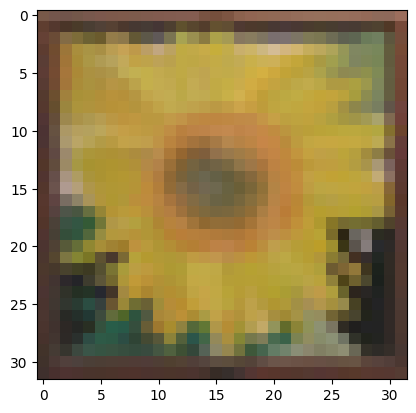

In [163]:
plt.imshow(image)

In [164]:
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

In [165]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

In [166]:
similarity

tensor([[1.0419e-04, 1.8573e-04, 1.1504e-05, 1.8954e-05, 2.7013e-04, 6.8998e-04,
         1.0097e-04, 7.4506e-06, 2.6608e-04, 2.0719e-04, 8.8596e-04, 2.3842e-04,
         7.1585e-05, 7.0512e-05, 1.6391e-04, 6.3181e-05, 2.2531e-05, 1.6987e-05,
         6.7949e-04, 2.3472e-04, 6.0320e-05, 3.8922e-05, 1.9908e-05, 5.7220e-04,
         6.1274e-05, 3.9518e-05, 6.3801e-04, 8.4543e-04, 4.7684e-06, 4.1842e-04,
         7.6234e-05, 4.2510e-04, 1.8656e-05, 2.8491e-05, 2.0206e-05, 2.5392e-04,
         1.3375e-04, 2.7294e-03, 7.9870e-05, 3.5238e-04, 5.5790e-05, 8.7214e-04,
         7.9441e-04, 4.3452e-05, 1.7822e-05, 9.1910e-05, 7.0930e-06, 9.4175e-06,
         2.6345e-05, 9.8682e-01]], device='cuda:0', dtype=torch.float16)

In [167]:
values

tensor([9.8682e-01, 2.7294e-03, 8.8596e-04, 8.7214e-04, 8.4543e-04],
       device='cuda:0', dtype=torch.float16)

In [168]:
indices

tensor([49, 37, 10, 41, 27], device='cuda:0')

In [169]:
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{json_values[index]:>16s}: {100 * value.item():.2f}%")


Top predictions:

       sunflower: 98.68%
    sweet_pepper: 0.27%
            baby: 0.09%
            girl: 0.09%
             bee: 0.08%


In [170]:
indices

tensor([49, 37, 10, 41, 27], device='cuda:0')

In [171]:
values

tensor([9.8682e-01, 2.7294e-03, 8.8596e-04, 8.7214e-04, 8.4543e-04],
       device='cuda:0', dtype=torch.float16)

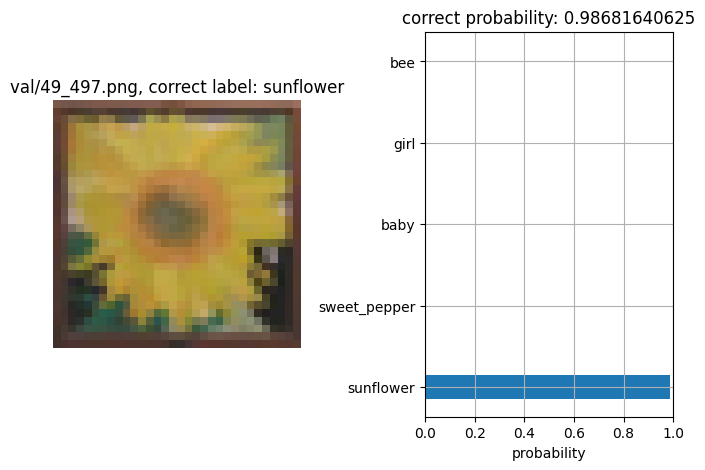

In [172]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))

plt.subplot(1, 2, 1)
plt.title(f"val/{a}_497.png, correct label: {json_values[a]}")
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"correct probability: {similarity[0,a]}")
plt.barh([json_values[i] for i in indices], values.cpu(), height=0.3)
plt.grid()
plt.xlabel("probability")
plt.xlim(0,1)

plt.subplots_adjust(wspace=0.5)
plt.show()

In [54]:
image = preprocess(Image.open("hw3_data/p1_data/val/25_497.png")).unsqueeze(0).to(device)

In [55]:
text.shape

torch.Size([50, 77])

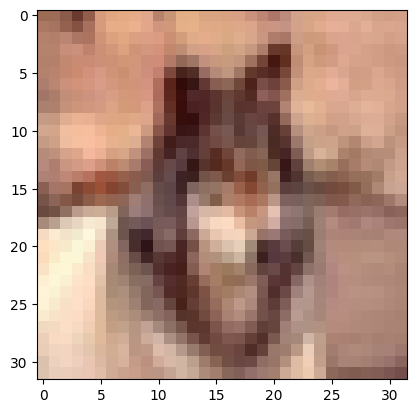

In [56]:
plt.imshow(Image.open("hw3_data/p1_data/val/25_497.png"))

In [57]:
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

In [58]:
print("Label probs:", probs)

Label probs: [[2.4462e-04 5.9605e-04 1.9531e-03 1.3145e-02 5.2595e-04 1.0786e-03
  1.2617e-03 7.5623e-02 2.9793e-03 4.7135e-04 6.1111e-03 1.3638e-03
  6.1464e-04 4.6600e-02 8.0948e-03 2.4170e-02 5.6534e-03 1.8433e-01
  2.5883e-03 2.2850e-03 3.6716e-04 1.7893e-04 2.3438e-02 9.1782e-03
  7.0763e-04 4.7803e-01 1.2226e-03 1.3428e-03 1.2035e-03 2.6703e-03
  2.9039e-04 1.0138e-03 4.4990e-04 4.2686e-03 7.5340e-04 1.0559e-02
  1.7786e-03 4.4464e-02 1.4744e-03 5.0163e-04 6.7520e-04 7.4883e-03
  4.4990e-04 5.1785e-04 2.9969e-04 1.0078e-02 1.2226e-03 2.0466e-03
  1.3351e-02 2.3329e-04]]


In [61]:
probs.argmax()

25

In [25]:
import json
with open('hw3_data/p1_data/id2label.json', newline='') as file:
    data = json.load(file)

In [30]:
data

{'0': 'bicycle',
 '1': 'chair',
 '2': 'camel',
 '3': 'rabbit',
 '4': 'lamp',
 '5': 'clock',
 '6': 'forest',
 '7': 'fox',
 '8': 'porcupine',
 '9': 'bed',
 '10': 'baby',
 '11': 'dinosaur',
 '12': 'skyscraper',
 '13': 'willow_tree',
 '14': 'apple',
 '15': 'raccoon',
 '16': 'skunk',
 '17': 'kangaroo',
 '18': 'oak_tree',
 '19': 'worm',
 '20': 'beetle',
 '21': 'wardrobe',
 '22': 'possum',
 '23': 'pine_tree',
 '24': 'house',
 '25': 'wolf',
 '26': 'rose',
 '27': 'bee',
 '28': 'dolphin',
 '29': 'woman',
 '30': 'mushroom',
 '31': 'television',
 '32': 'bus',
 '33': 'mouse',
 '34': 'castle',
 '35': 'boy',
 '36': 'lizard',
 '37': 'sweet_pepper',
 '38': 'mountain',
 '39': 'palm_tree',
 '40': 'couch',
 '41': 'girl',
 '42': 'cup',
 '43': 'crab',
 '44': 'elephant',
 '45': 'lion',
 '46': 'streetcar',
 '47': 'otter',
 '48': 'shrew',
 '49': 'sunflower'}